# Neural-Admixture vs ADMIXTURE for Global Ancestry

### Global Ancestry Analysis

It is a method of inferring ancestry proportions within an individual or a population using genetic data. In this notebook we will explore two variants of ADMIXTURE Model: 

- ADMIXTURE program (By Alexander et al)

- Neural Admixture (By Mantes et al)


### But first, what is the ADMIXTURE Model?

The major components of the ADMIXTURE model are:

- $K$ source populations (chosen by user).

- $q_{ik}$ gives the fraction of individual $i$’s genome that is from population $K$.

- $f_{jk}$ gives the minor allele frequency of SNP $j$ in population $K$.

For a fixed value of $K$, it attempts to infer $Q = \{q_{ik}\}$ and $F = \{f_{jk}\}$ from the data. ADMIXTURE solves this as a maximum likelihood problem.

Based on Hardy-Weinberg Equilibrium to calculate MAF $p$, instead of using $p$ it uses $\sum_k q_{ik}f_{kj}$, which computes a weighted MAF, weighted by the ancestry components of a particular individual. For a single sample, the probability of each possible genotype for each SNP is given by: 

- $P(00) = \left[ \sum_k q_{ik}(1 - f_{kj}) \right]^2$

- $P(01) = 2 \left[ \sum_k q_{ik}f_{kj} \right] \left[ \sum_k q_{ik}(1 - f_{kj}) \right]$

- $P(11) = \left[ \sum_k q_{ik}f_{kj} \right]^2$

Let $g_{ij}$ be the genotype (number of copies of the minor allele at SNP $j$ in sample $i$). Then, above probabilities can be written as:

$$P(g_{ij} | Q, F) = \left[ \sum_k q_{ik} f_{kj} \right]^{g_{ij}} \left[ \sum_k q_{ik} (1 - f_{kj}) \right]^{2 - g_{ij}}$$

We can compute the likelihood of the entire data by assuming each SNP and each sample are independent. 

#### The goal is to find $Q$ and $F$ that maximize the likelihood below:

$$L(Q, F) = \prod_i \prod_j P(g_{ij} | Q, F)$$


### ADMIXTURE Program (By Alexander et al)

It uses a combination of Expectation-Maximization and Block Relaxation Algorithm to solve the optimization problem presented above.

### Neural Admixture (By Mantes et al)

This uses a neural network AutoEncoder that follows the same modeling assumptions as ADMIXTURE. 

The input sequence $x$ is projected into 64 dimensions using a linear layer $\theta_1$ and processed by a GELU non-linearity $\sigma_1$. The cluster assignment estimates $Q$ are computed by feeding the 64-dimensional sequence to a K-neuron layer (parametrized by $\theta_2$) activated with a softmax $\sigma_2$. Finally, the decoder outputs a reconstruction of the input $\tilde{x}$ using a linear layer with weights $F$.


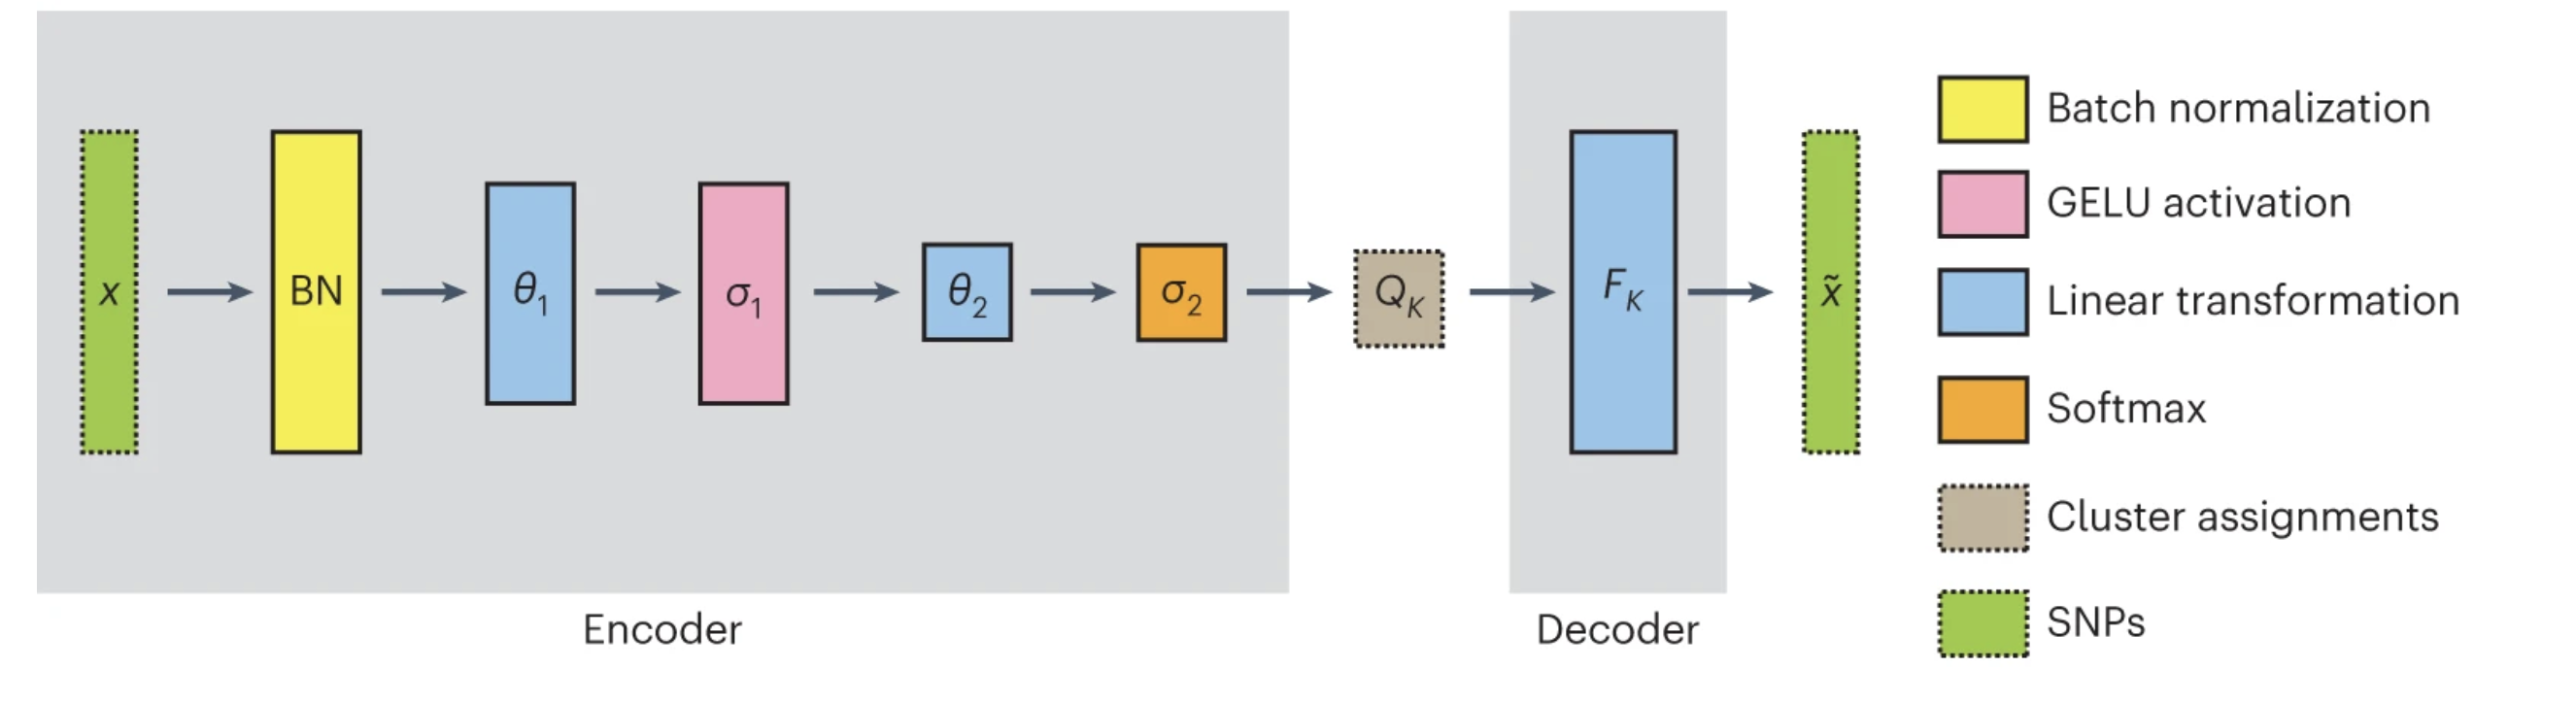

## Let's run both the programs to see their output

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import os
import shutil
from time import time

In [2]:
PREFIX = "example_data" 
data_dir = "example_data/"
output_dir = "outputs" 
os.makedirs(output_dir, exist_ok=True)
K_values = [3] # running only for K = 3 populations for now

In [3]:
sampleinfo = pd.read_csv(f"{data_dir}IGSR_1000Genomes.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open(f"{data_dir}{PREFIX}.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]

In [4]:
def plot(file_path):
    fig = plt.figure()
    fig.set_size_inches((10, 8))

    plotind = 1

    ax = fig.add_subplot(3, 1, plotind)

    #data = pd.read_csv("outputs/neural_admixture.%s.Q"%K, delim_whitespace=True, header=None)
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    cols = list(data.columns)
    data["sample"] = samples
    data["pop"] = pops
    data = data.sort_values(["pop"]+cols)
    data.plot.bar(stacked=True, ax=ax, width=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Only plot label for first sample in each pop
    xticklabels = []
    currpop = ""
    for i in range(data.shape[0]):
        if data["pop"].values[i] == currpop:
            xticklabels.append("")
        else:
            xticklabels.append(data["pop"].values[i])
            currpop = data["pop"].values[i]
    ax.set_xticklabels(xticklabels)

    plotind += 1
    fig.tight_layout()
    

## ADMIXTURE Program

Running ADMIXTURE for K=3...
Process complete. Time taken - 49.50s


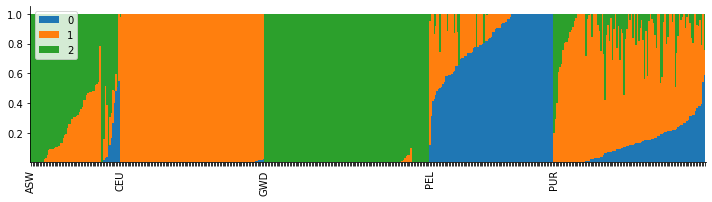

In [7]:
for K in K_values:
    start_time = time()
    print(f"Running ADMIXTURE for K={K}...")
    # Construct the command to run
    cmd = f"admixture --cv {data_dir}{PREFIX}.bed {K}"
    
    # Execute the command and capture the output
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    # Decode and print the output to console
#     print(stdout.decode())
    if (stderr):
        print(stderr.decode())
    else:
        print(f"Process complete. Time taken - {(time() - start_time):.2f}s")
    
    files = [f"{PREFIX}.{K}.P", f"{PREFIX}.{K}.Q"]
    out_files = [f"admixture.{K}.P", f"admixture.{K}.Q"]
    
    # Move files to output folder
    for old,new in zip(files,out_files):
        if os.path.exists(old):
            shutil.move(old, os.path.join(output_dir, new))
            
    #Plotting the graph for ADMIXTURE
    plot(f"outputs/admixture.{K}.Q")


## Neural ADMIXTURE

Running Neural ADMIXTURE for K=3...
/home/gsaluja/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/home/gsaluja/.local/lib/python3.9/site-packages/neural_admixture/src/snp_reader.py:55: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  _, _, G = read_plink(str(Path(file).with_suffix("")))
/home/gsaluja/.local/lib/python3.9/site-packages/neural_admixture/src/snp_reader.py:55: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  _, _, G = read_plink(str(Path(file).with_suffix("")))
Mapping files: 100%|██████████| 3/3 [00:00<00:00, 16.52it/s]
/home/gsaluja/.local/lib/python3.9/site-packages/dask/core.p

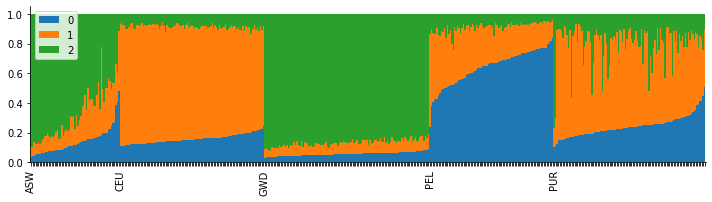

In [8]:
for K in K_values:
    start_time = time()
    print(f"Running Neural ADMIXTURE for K={K}...")
    
    cmd = f"~/.local/bin/neural-admixture train --k {K} --data_path {data_dir}{PREFIX}.bed --save_dir {output_dir} --name neural_adm_{PREFIX} --max_epochs 500 --seed 43 --initialization pcarchetypal"
    
    # Execute the command and capture the output
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
#     Decode and print the output to console
#     print(stdout.decode())
    if stderr:
        print(stderr.decode())
    else:
        print(f"Process complete")
    print(f"Time taken - {(time() - start_time):.2f}s")
    
    plot(f"outputs/neural_adm_{PREFIX}.{K}.Q")


## Runtime and Memory Comparison

| Algorithms            | Time     | Memory | 
| :----------------     | :------: | ----: |
| ADMIXTURE (K=3)       |   49.5s   | TODO |
| Neural ADMIXTURE (K=3)|   305.8s   | TODO |
| ADMIXTURE (K=5)       |  293.2s   | TODO |
| Neural ADMIXTURE (K=5)|  306.5s   | TODO |

In [9]:
# Code to calculate runtime
# K_values = [3,  5]

In [18]:
# import psutil
# import os

In [21]:
# for K in K_values:
#     print(f"Running ADMIXTURE for K={K}...\n")
#     cmd = f"admixture --cv {data_dir}{PREFIX}.bed {K}"
    
#     start_time = time()
    
#     process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = process.communicate()
    
#     print(f"Time taken - {(time() - start_time):.2f}s \n")
    
#     print(stdout.decode())
#     print(stderr.decode())
    
#     files = [f"{PREFIX}.{K}.P", f"{PREFIX}.{K}.Q"]
#     out_files = [f"admixture.{K}.P", f"admixture.{K}.Q"]
    
#     for old,new in zip(files,out_files):
#         if os.path.exists(old):
#             shutil.move(old, os.path.join(output_dir, new))

Running ADMIXTURE for K=3...

Time taken - 49.50s 

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Cross-validation will be performed.  Folds=5.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Size of G: 462x26499
Performing five EM steps to prime main algorithm
1 (EM) 	Elapsed: 0.555	Loglikelihood: -6.08554e+06	(delta): 1.361

In [22]:
# for K in K_values:
#     print(f"Running Neural ADMIXTURE for K={K}...\n")
#     cmd = f"~/.local/bin/neural-admixture train --k {K} --data_path {data_dir}{PREFIX}.bed --save_dir {output_dir} --name neural_adm_{PREFIX} --max_epochs 500 --seed 43 --initialization pcarchetypal"
    
#     start_time = time()
    
#     process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = process.communicate()
    
#     print(f"Time taken - {(time() - start_time):.2f}s \n")
    
#     print(stdout.decode())
#     print(stderr.decode())

Running Neural ADMIXTURE for K=3...

Time taken - 305.80s 

INFO:neural_admixture.entry:Neural ADMIXTURE - Version 1.4.0
INFO:neural_admixture.entry:[CHANGELOG] Mean imputation for missing data was added in version 1.4.0. To reproduce old behaviour, please use `--imputation zero` when invoking the software.
INFO:neural_admixture.entry:[CHANGELOG] Default P initialization was changed to 'pckmeans' in version 1.3.0.
INFO:neural_admixture.entry:[CHANGELOG] Warmup training for initialization of Q was added in version 1.3.0 to improve training stability (only for `pckmeans`).
INFO:neural_admixture.entry:[CHANGELOG] Convergence check changed so it is performed after 15 epochs in version 1.3.0 to improve training stability.
INFO:neural_admixture.entry:[CHANGELOG] Default learning rate was changed to 1e-5 instead of 1e-4 in version 1.3.0 to improve training stability.
INFO:numexpr.utils:Note: detected 256 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment v